In [1]:
import torch
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import random
rng = random.Random(42)

/home/jdias/miniconda3/envs/vf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [2]:
#model loading functions

def choose_device(device):
    if device==0:
        return 'cuda:0'
    elif device==1:
        return 'cuda:1'
    elif device ==-1:
        return 'cpu'
    else:
        raise Exception('Return 0 or 1 for GPUs or -1 for CPU')

def load_device(cuda_id):
    cuda = choose_device(cuda_id)
    device = torch.device(cuda if torch.cuda.is_available() else "cpu")
    return device

def load_AutoModel(model_id,cuda_id):
    
    tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side = "left") 
    tokenizer.pad_token_id = tokenizer.eos_token_id #required in llama because no padding token is defined
    model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    device = load_device(cuda_id)
    model = model.to(device)

    return tokenizer, model, device, terminators

In [3]:
#prompt related functions

def load_prompts(prompt_type, prompt_topic):
    #load prompt from .txt
    if prompt_type == 'completion':
        with open('../prompts-comp/'+prompt_topic+'.txt') as file:
            prompt = file.read()
    elif prompt_type == 'generation':
        with open('../prompts-gen/'+prompt_topic+'.txt') as file:
            prompt = file.read()
        prompt = json.loads(prompt, strict=False)
    return prompt

def prepare_llama_prompt(tokenizer, prompt, device):
    text = tokenizer.apply_chat_template(prompt, add_generation_prompt=True, tokenize=False) 
    inputs = tokenizer(text, padding="longest", return_tensors="pt") #transform into pt tensors
    inputs = {key: val.to(device) for key, val in inputs.items()} #move inputs into cuda
    return inputs

In [4]:
#pipeline functions

def compute_layer_vectors(layer_activation):
    return layer_activation[1:]-layer_activation[:-1] #matrix except first_row - matrix except last_row

def compute_vectors(hidden_states):
    return [compute_layer_vectors(layer) for layer in hidden_states]

def compute_angle_layer(layer_vectors):
    angles=[]

    for i in range(layer_vectors.shape[0]-1): 
        #grab consecutive vectors
        a = layer_vectors[i,:]
        b = layer_vectors[i+1,:]
        cos_value = torch.dot(a, b) / (torch.norm(a) * torch.norm(b))
        cos_value = torch.clamp(cos_value, -1, 1)
        angles.append(torch.acos(cos_value)) #angle equation from vec dot product

    return torch.tensor(angles, dtype=torch.bfloat16)

def compute_angle(vector_transitions_trajectory):
    return [compute_angle_layer(layer_vectors) for layer_vectors in vector_transitions_trajectory]

def average_layer_angle(layer_dot_product):
    return layer_dot_product.nanmean() #ignore NaNs when computing mean

def average_angle(dot_product_list):
    return torch.stack([average_layer_angle(layer_dot_product) for layer_dot_product in dot_product_list])

def sum_layer_energy(average_layer_dot_product):
    return average_layer_dot_product.sum()

def energy_pipeline(layer_hidden_states):
    if not isinstance(layer_hidden_states, list):
        raise TypeError("Expected a list of tensors (one per layer of the model). Don't include the model's embedding layer")
    return sum_layer_energy(average_angle(compute_angle(compute_vectors(layer_hidden_states)))).item()

def energy_pipeline_layer(layer_hidden_states):
    if not isinstance(layer_hidden_states, list):
        raise TypeError("Expected a list of tensors (one per layer of the model). Don't include the model's embedding layer")
    return average_angle(compute_angle(compute_vectors(layer_hidden_states)))

In [ ]:
#handling of LLM functions

def inference_activations(model, gen_ids):
    #pass the full generation through the model 
    with torch.no_grad():
        full_outputs = model(
            input_ids=gen_ids,
            output_hidden_states=True,
            return_dict=True
        )
    #remove 1st tensor dimension so its 2D
    return [layer[0] for layer in full_outputs.hidden_states[1:]] #list with pt tensor of activations in each element

def energy_loop_llama(model_inputs, num_generations, generations, model):
    tensor_size_prompt = model_inputs['input_ids'].shape[1] #obtain prompt token size
    energy_values = []
    for i in range(num_generations):
        tensor = generations[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
        activations = inference_activations(model,tensor)
        energy_values.append(energy_pipeline_layer(activations))

    return energy_values

def llama_gen(model, inputs, tokenizer, terminators, num_generations):
    generations = model.generate(
        **inputs,
        max_new_tokens=400,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=terminators,
        num_return_sequences=num_generations  
    )

    return generations

In [7]:
#plotting functions

def mean_and_std_by_layer_plots(all_lists):
    plt.figure(figsize=(12, 6))

    for name, energy_list, color in all_lists:
        #stack tensors to 2D array and convert to float32
        data = torch.stack([t.float() for t in energy_list]).numpy()
        
        #compute mean and std across layers for each neuron index
        mean_vals = np.mean(data, axis=0)
        std_vals = np.std(data, axis=0)
        
        x = np.arange(data.shape[1])
        
        #plot mean line with shaded variance
        plt.plot(x, mean_vals, label=name, color=color)
        plt.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

    plt.xlabel('Layer index')
    plt.ylabel('Mean energy value')
    plt.title('Energy values per layer comparison')
    plt.legend()
    plt.show()

def bar_per_layer_plots(all_lists):
    plt.figure(figsize=(12, 6))

    cap_width = 0.2  # width of horizontal caps for min/max

    for name, energy_list, color in all_lists:
        data = torch.stack([t.float() for t in energy_list]).numpy()
        
        min_vals = np.min(data, axis=0)
        max_vals = np.max(data, axis=0)
        mean_vals = np.mean(data, axis=0)
        
        x = np.arange(data.shape[1])
        
        #plot vertical line for min-max
        for xi, vmin, vmax in zip(x, min_vals, max_vals):
            plt.plot([xi, xi], [vmin, vmax], color=color, linewidth=2)
            plt.plot([xi - cap_width, xi + cap_width], [vmin, vmin], color=color, linewidth=2)
            plt.plot([xi - cap_width, xi + cap_width], [vmax, vmax], color=color, linewidth=2)
        
        #optionally plot mean line
        plt.plot(x, mean_vals, color=color, linestyle='--', alpha=0.7)

    plt.xlabel('Layer index')
    plt.ylabel('Mean energy value')
    plt.title('Energy values per layer comparison')
    plt.show()

## Load model

In [6]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
tokenizer, model, device, terminators = load_AutoModel(model_id, cuda_id=0)

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 134.70it/s]


## First run on prompt-based stories

In [ ]:
def prompt_to_coherence_vectors(prompt_type, prompt_topic, tokenizer, device):

    #load prompt and generations tensors
    prompt = load_prompts(prompt_type, prompt_topic)
    checkpoint_path = "../checkpoints/ids_" + prompt_topic + ".pt"
    generations = torch.load(checkpoint_path)
    model_inputs = prepare_llama_prompt(tokenizer, prompt, device)

    #prepare variables for coherence inference loop
    nr_gens = generations.shape[0]
    tensor_size_prompt = model_inputs['input_ids'].shape[1]
    coherence_values = []

    #infer each gen to get activations
    for i in range(nr_gens):
        tensor = generations[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
        activations = inference_activations(model,tensor)
        coherence_values.append(energy_pipeline_layer(activations))
    
    return coherence_values

In [13]:
viktor_values = prompt_to_coherence_vectors(prompt_type="generation", prompt_topic="viktor", tokenizer=tokenizer, device=device)

In [14]:
prague_values = prompt_to_coherence_vectors(prompt_type="generation", prompt_topic="prague", tokenizer=tokenizer, device=device)

In [15]:
science_values = prompt_to_coherence_vectors(prompt_type="generation", prompt_topic="sciencefic", tokenizer=tokenizer, device=device)

## First plots (prompt-based)

In [17]:
first_prompt_gens = [
    ("Viktor", viktor_values, "blue"),
    ("Prague", prague_values, "green"),
    ("Science", science_values, "red")
]

#### Mean and std - shaded plots

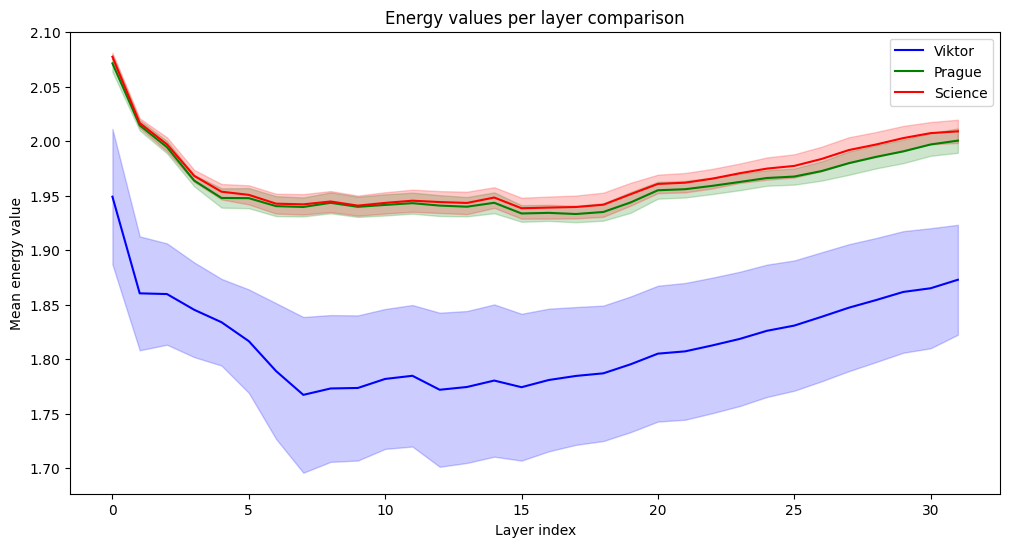

In [ ]:
mean_and_std_by_layer_plots(all_lists=first_prompt_gens)

#### Max-min bar plots

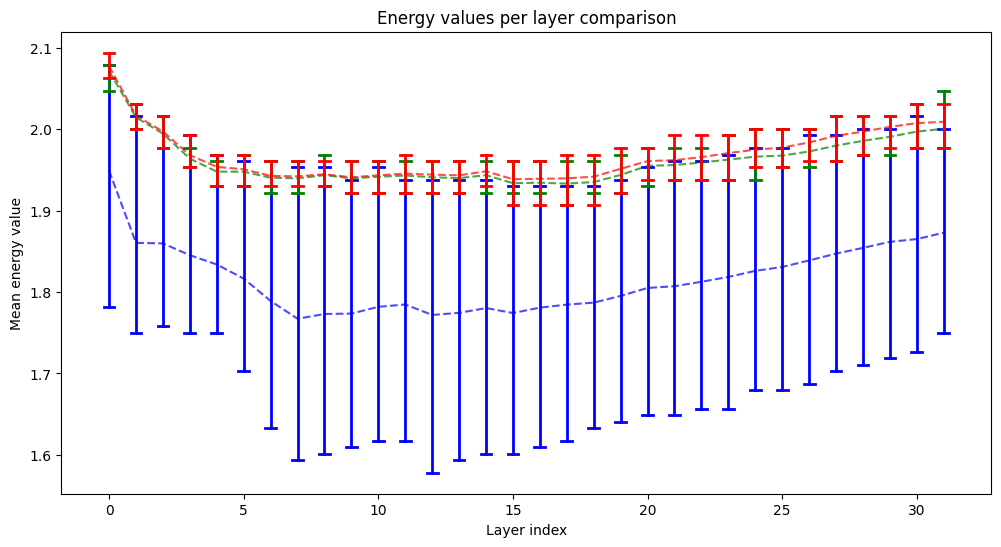

In [21]:
bar_per_layer_plots(all_lists=first_prompt_gens)

# Prompt-generated vs Shuffled

We don't have the decoded versions of the prompt-based generations, we only have the encoded tokens, so we need to obtain new generations!

In [12]:
def split_sentences(text):
    """
    Fast splitter on . ! ?
    """
    text = text.strip()
    if not text:
        return []
    sents = re.split(r'(?<=[.!?])\s+', text)
    return [s for s in sents if s]

def shuffle_sentences(text, rng):
    sents = split_sentences(text)
    if len(sents) <= 1:
        return text
    
    shuffled = sents[:] #copy
    #rng.shuffle(shuffled)
    random.shuffle(shuffled)

    #ensure itss actually different 
    if shuffled == sents:
        shuffled = sents[1:] + sents[:1]
    return " ".join(shuffled) #join sentences again

def load_prompt_and_gen(prompt_type, prompt_topic, tokenizer, terminators, device):
    prompt = load_prompts(prompt_type, prompt_topic)
    model_inputs = prepare_llama_prompt(tokenizer, prompt, device)
    gen_ids = llama_gen(model, model_inputs, tokenizer, terminators, num_generations=100)

    return gen_ids, model_inputs

def gen_ids_to_decoded(tokenizer, model_inputs, gen_ids):
    prompt_text = tokenizer.decode(model_inputs['input_ids'][0], skip_special_tokens=True)
    decoded_gens = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

    return [decoded_generation[len(prompt_text):] for decoded_generation in decoded_gens] #list of decoded stories

def shuffle_and_encode(rng, decoded_stories, gen_ids, tokenizer):

    shuffled_stories = [shuffle_sentences(s, rng) for s in decoded_stories]
    nr_gens = len(shuffled_stories)
    max_gen_size = int(getattr(gen_ids, "shape", [nr_gens, 0])[1])  

    shuffled_encoded = tokenizer(
        shuffled_stories,
        add_special_tokens=False,         
        padding="max_length",
        truncation=True,
        max_length=max_gen_size,
        return_tensors="pt",
    )
    shuffled_input_ids = shuffled_encoded["input_ids"]
    shuffled_input_ids = shuffled_input_ids.to(device)   

    return shuffled_input_ids

def prompt_to_shuffled(prompt_type, prompt_topic, tokenizer, terminators, device, rng):
    
    gen_ids, model_inputs = load_prompt_and_gen(prompt_type, prompt_topic, tokenizer, terminators, device)

    decoded_stories = gen_ids_to_decoded(tokenizer, model_inputs, gen_ids)
    shuffled_input_ids = shuffle_and_encode(rng, decoded_stories, gen_ids, tokenizer)

    return model_inputs, gen_ids, shuffled_input_ids

def get_special_ids_set(tokenizer):
    #ensure pad_token_id at least exists
    if getattr(tokenizer, "pad_token_id", None) is None:
        raise ValueError("tokenizer.pad_token_id is not set. Set it or use a tokenizer with pad token.")
    
    return set(tokenizer.all_special_ids)

def strip_special_tokens(tensor_ids, tokenizer):
    clean_sequences = []
    lengths = []
    N, L = tensor_ids.shape
    special_ids = get_special_ids_set(tokenizer)

    for i in range(N):
        row = tensor_ids[i]
        ids = row.tolist()

        first, last = None, None
        for idx, tok in enumerate(ids): #find first non special token
            if tok not in special_ids:
                first = idx #save it
                break
    
        for idx in range(len(ids)-1, -1, -1): #iterate from the back of the tensor 
            if ids[idx] not in special_ids: #until a normal token
                last = idx #save it
                break
            
        seq = row[first:last+1].clone()
        clean_sequences.append(seq)
        lengths.append(seq.shape[0])

    return clean_sequences, lengths
    
def inference_loop(gen_ids, model_inputs, tokenizer, shuffle = False, skip_tokens = False):

    coherence_energies =[]
    tensor_size_prompt = model_inputs['input_ids'].shape[1]

    gen_only = gen_ids.clone()
    if shuffle == False:
        gen_only = gen_ids[:, tensor_size_prompt:]

    if skip_tokens == True:
        clean_sequences, _ = strip_special_tokens(gen_only, tokenizer)
        for seq in clean_sequences:
            if seq.numel() == 0:
                continue #handle empty generation 
            tensor = seq.unsqueeze(0)  #shape [1, seq_len]
            activations = inference_activations(model, tensor)   
            coherence_energies.append(energy_pipeline_layer(activations))

        return coherence_energies
    
    else:
        for i in range(gen_only.shape[0]):
            tensor = gen_only[i].unsqueeze(0)
            activations = inference_activations(model,tensor)
            coherence_energies.append(energy_pipeline_layer(activations))
        
        return coherence_energies
    

def per_layer_variance(energy_list, unbiased=False):
    if not energy_list:
        raise ValueError("energy_list is empty")

    processed = []
    for t in energy_list:
        if not isinstance(t, torch.Tensor):
            raise TypeError("All items in energy_list must be torch.Tensor")
        processed.append(t.to(torch.float32).flatten())

    stacked = torch.stack(processed, dim=0)  #(generations, layers)
    var_per_layer = torch.var(stacked, dim=0, unbiased=unbiased)

    return var_per_layer

def plot_layer_variance(all_lists):
    plt.figure(figsize=(10, 6))

    for name, energy_list, color in all_lists:
        var_tensor = per_layer_variance(energy_list)
        x = np.arange(len(var_tensor))
        plt.plot(x, var_tensor.numpy(), label=name, color=color)

    plt.xlabel("Layer index")
    plt.ylabel("Variance")
    plt.title("Per-layer Variance Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

def per_layer_ttests(listA, listB, alpha=0.05):
    """
    Compare two sets of activations per layer using t-tests with FDR correction.
    
    listA, listB: lists of PyTorch tensors (1x52 or 52,)
    alpha: significance level for FDR-corrected p-values
    """
    #ensure tensors are 2D and float32
    A = torch.cat([x.unsqueeze(0).to(torch.float32) if x.ndim == 1 else x.to(torch.float32) for x in listA], dim=0).cpu().numpy()
    B = torch.cat([x.unsqueeze(0).to(torch.float32) if x.ndim == 1 else x.to(torch.float32) for x in listB], dim=0).cpu().numpy()
    
    pvals = []
    for col in range(A.shape[1]):
        _, p = ttest_ind(A[:, col], B[:, col], equal_var=False)
        pvals.append(p)
    
    # Multiple comparison correction (FDR)
    reject, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    
    results = {
        "pvals_raw": pvals,
        "pvals_corrected": pvals_corrected.tolist(),
        "significant_layers": [i for i, sig in enumerate(reject) if sig]
    }
    
    return results

### Viktor prompt runs

In [11]:
tokenizer.padding_side = "right"

viktor_model_inputs, viktor_ids, shuffled_viktor_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="viktor", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
viktor_energies_right = inference_loop(viktor_ids, viktor_model_inputs, tokenizer, shuffle = False, skip_tokens = False)
shuffled_viktor_energies_right = inference_loop(shuffled_viktor_ids, viktor_model_inputs, tokenizer, shuffle = True, skip_tokens = False)

In [12]:
tokenizer.padding_side = "left"

viktor_model_inputs, viktor_ids, shuffled_viktor_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="viktor", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
viktor_energies_left = inference_loop(viktor_ids, viktor_model_inputs, tokenizer, shuffle = False, skip_tokens = False)
shuffled_viktor_energies_left = inference_loop(shuffled_viktor_ids, viktor_model_inputs, tokenizer, shuffle = True, skip_tokens = False)

In [ ]:
viktor_model_inputs, viktor_ids, shuffled_viktor_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="viktor", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
viktor_energies_skip_tokens = inference_loop(viktor_ids, viktor_model_inputs, tokenizer, shuffle = False, skip_tokens = True)
shuffled_viktor_energies_skip_token = inference_loop(shuffled_viktor_ids, viktor_model_inputs, tokenizer, shuffle = True, skip_tokens = True)

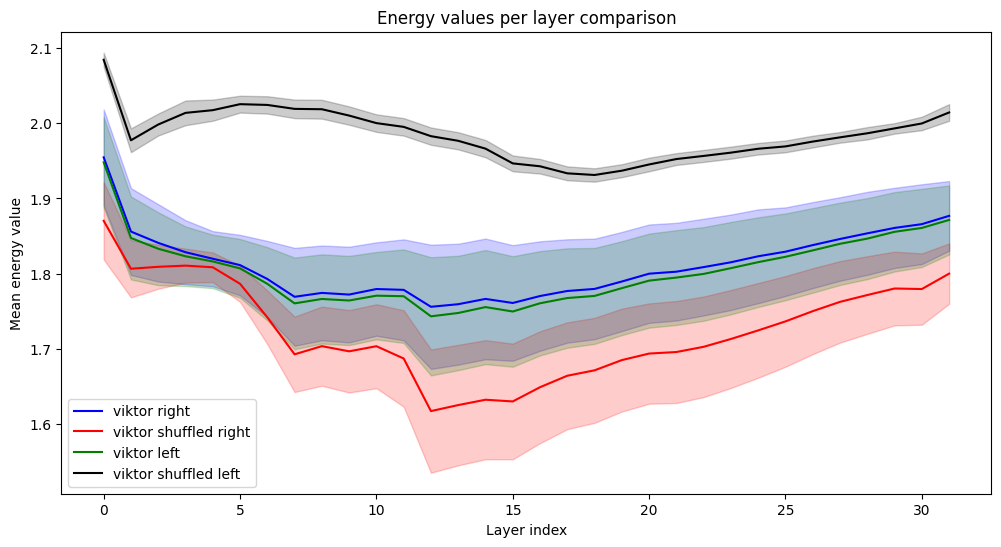

In [ ]:
viktor_lists = [
    ("viktor right", viktor_energies_right, "blue"),
    ("viktor shuffled right", shuffled_viktor_energies_right, "red"),
    ("viktor left", viktor_energies_left, "green"),
    ("viktor shuffled left", shuffled_viktor_energies_left, "black"),
]

mean_and_std_by_layer_plots(viktor_lists)

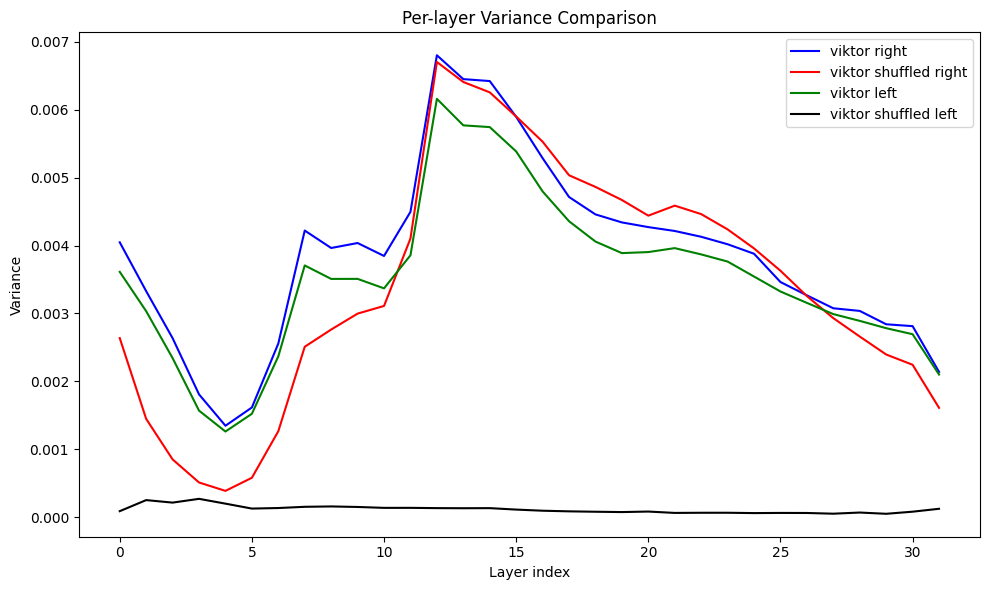

In [16]:
plot_layer_variance(all_lists=viktor_lists)

In [24]:
viktor_lists_skip_tokens = [
    ("viktor without tokens", viktor_energies_skip_tokens, "blue"),
    ("viktor shuffled without tokens right", shuffled_viktor_energies_skip_token, "red"),
]

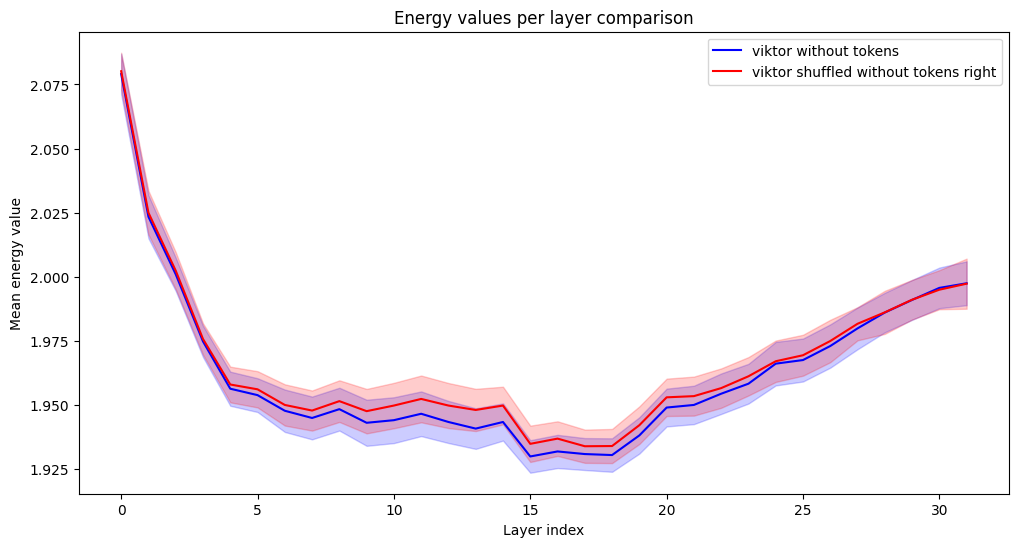

In [25]:
mean_and_std_by_layer_plots(viktor_lists_skip_tokens)

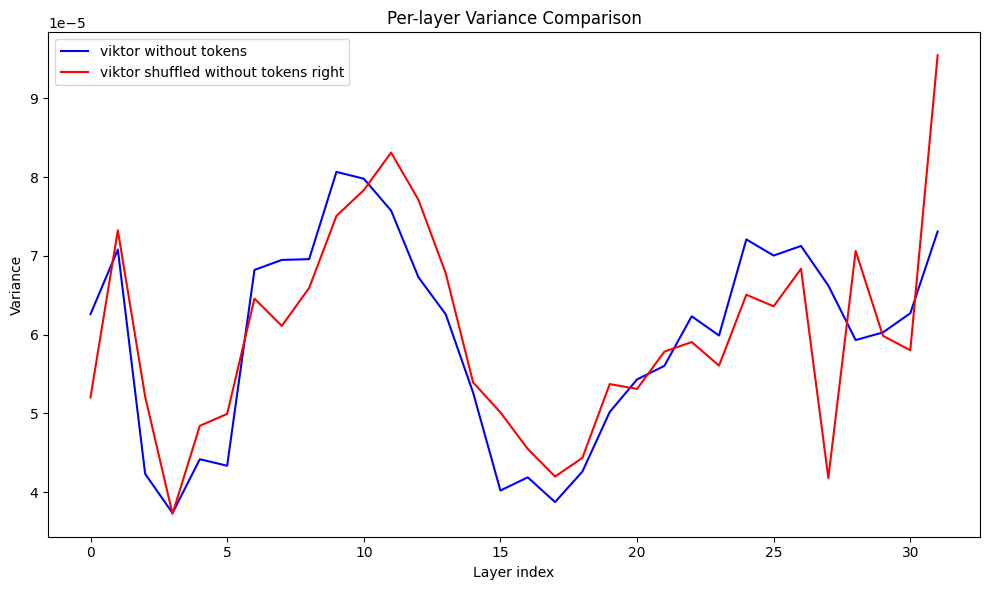

In [26]:
plot_layer_variance(all_lists=viktor_lists_skip_tokens)

### Sciencefic prompt runs

In [ ]:
tokenizer.padding_side = "right"

sciencefic_model_inputs, sciencefic_ids, shuffled_sciencefic_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="sciencefic", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
sciencefic_energies_right = inference_loop(sciencefic_ids, sciencefic_model_inputs, tokenizer, shuffle = False, skip_tokens = False)
shuffled_sciencefic_energies_right = inference_loop(shuffled_sciencefic_ids, sciencefic_model_inputs, tokenizer, shuffle = True, skip_tokens = False)

In [ ]:
tokenizer.padding_side = "left"

sciencefic_model_inputs, sciencefic_ids, shuffled_sciencefic_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="sciencefic", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
sciencefic_energies_left = inference_loop(sciencefic_ids, sciencefic_model_inputs, tokenizer, shuffle = False, skip_tokens = False)
shuffled_sciencefic_energies_left = inference_loop(shuffled_sciencefic_ids, sciencefic_model_inputs, tokenizer, shuffle = True, skip_tokens = False)

In [33]:
sciencefic_model_inputs, sciencefic_ids, shuffled_sciencefic_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="sciencefic", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
sciencefic_energies_skip_tokens = inference_loop(sciencefic_ids, sciencefic_model_inputs, tokenizer, shuffle = False, skip_tokens = True)
shuffled_sciencefic_energies_skip_token = inference_loop(shuffled_sciencefic_ids, sciencefic_model_inputs, tokenizer, shuffle = True, skip_tokens = True)

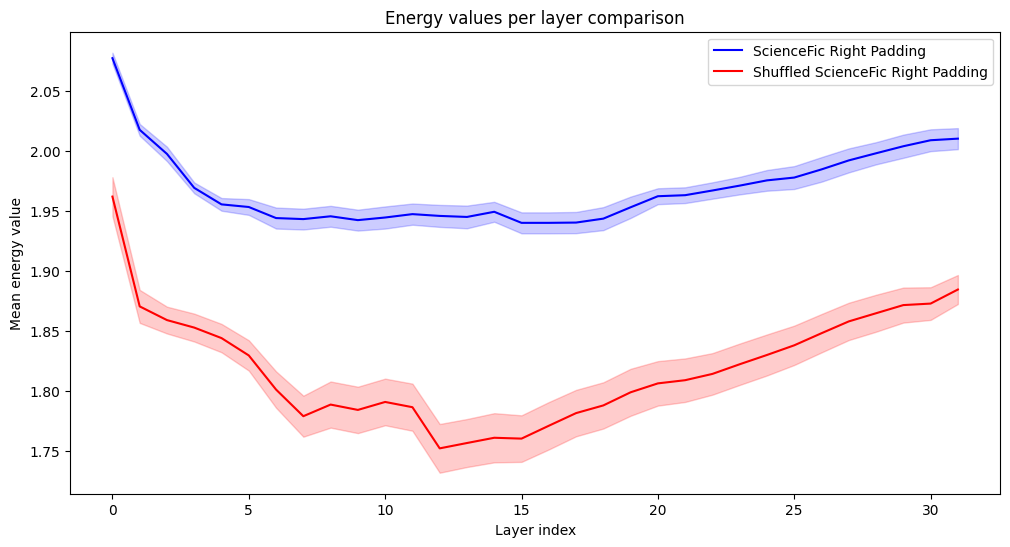

In [ ]:
sciencefic_right = [
    ("ScienceFic Right Padding", sciencefic_energies_right, "blue"),
    ("Shuffled ScienceFic Right Padding", shuffled_sciencefic_energies_right, "red"),
]
mean_and_std_by_layer_plots(sciencefic_right)

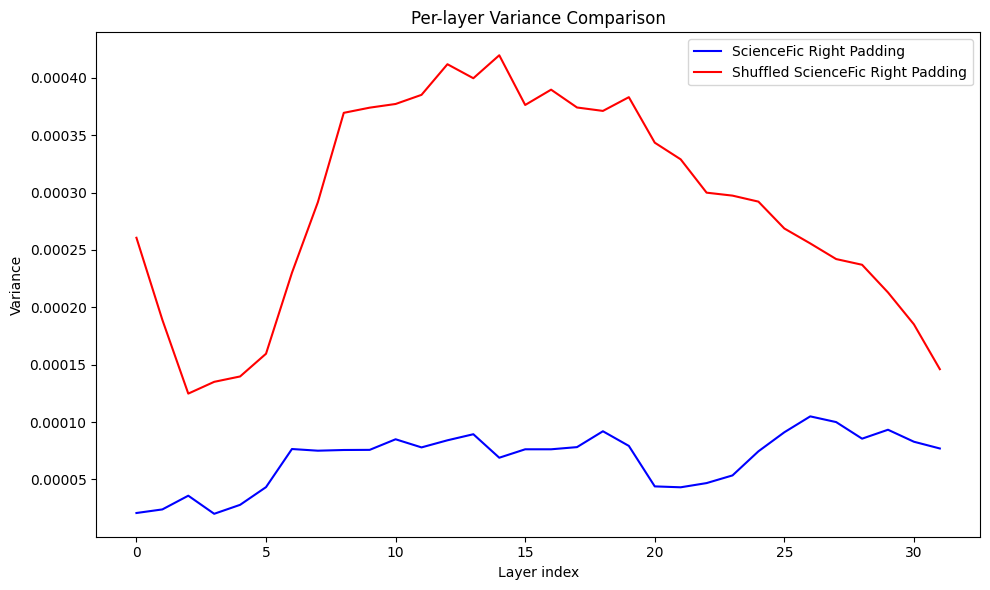

In [31]:
plot_layer_variance(all_lists=sciencefic_right)

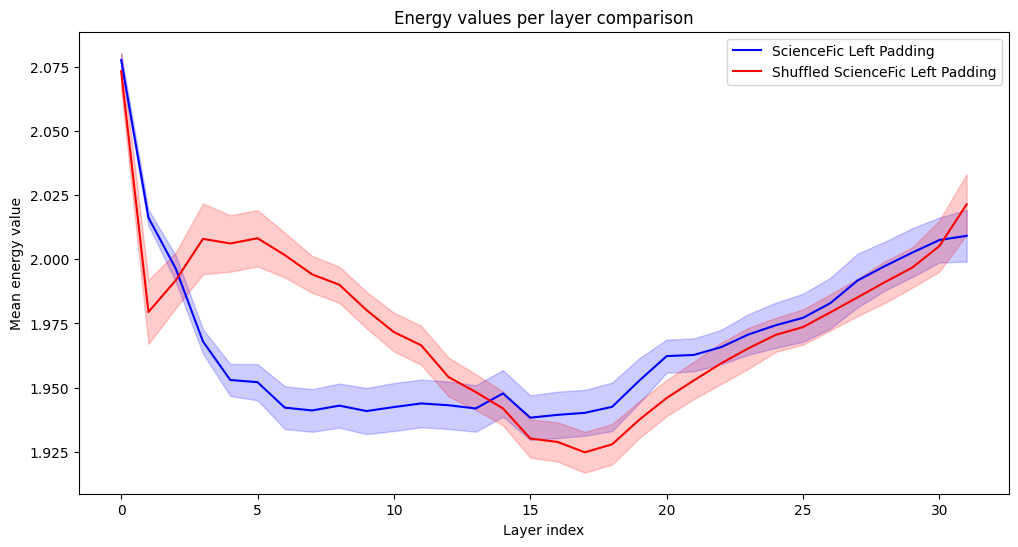

In [ ]:
sciencefic_left = [
    ("ScienceFic Left Padding", sciencefic_energies_left, "blue"),
    ("Shuffled ScienceFic Left Padding", shuffled_sciencefic_energies_left, "red"),
]
mean_and_std_by_layer_plots(sciencefic_left)

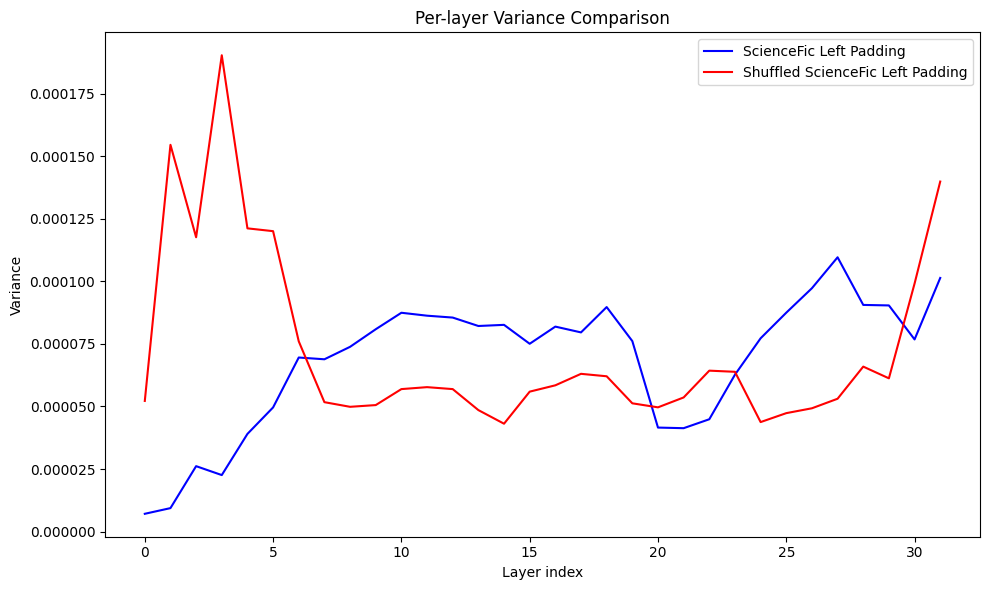

In [32]:
plot_layer_variance(all_lists=sciencefic_left)

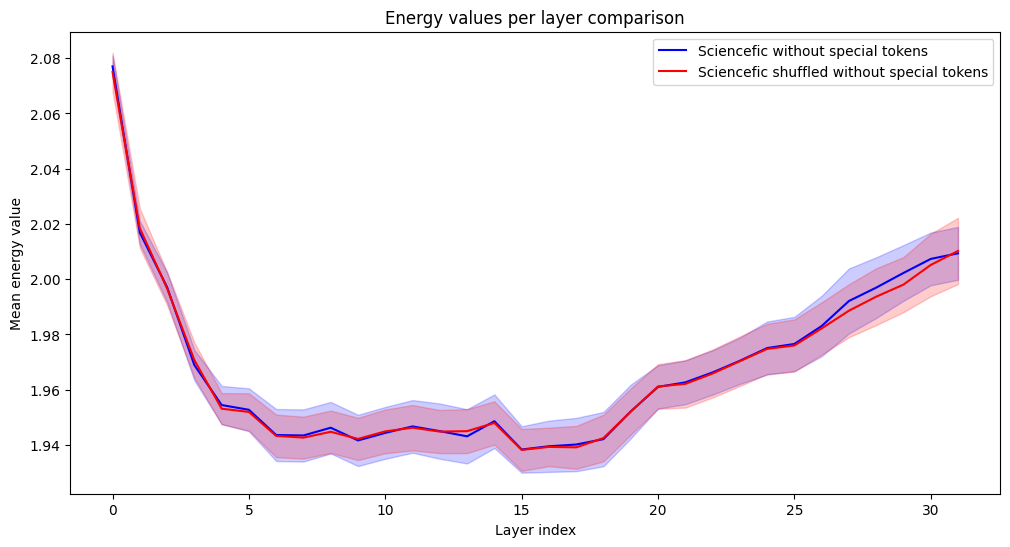

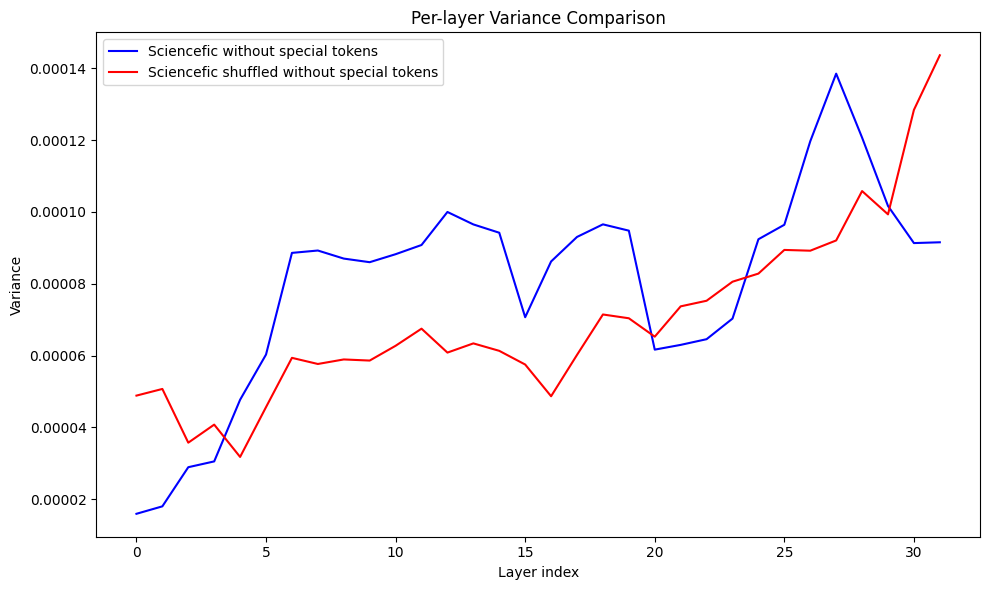

In [35]:
sciencefic_lists_skip_tokens = [
    ("Sciencefic without special tokens", sciencefic_energies_skip_tokens, "blue"),
    ("Sciencefic shuffled without special tokens", shuffled_sciencefic_energies_skip_token, "red"),
]
mean_and_std_by_layer_plots(sciencefic_lists_skip_tokens)
plot_layer_variance(all_lists=sciencefic_lists_skip_tokens)

### Prague prompt runs

In [8]:
tokenizer.padding_side = "right"

prague_model_inputs, prague_ids, shuffled_prague_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="prague", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
prague_energies_right = inference_loop(prague_ids, prague_model_inputs, tokenizer, shuffle = False, skip_tokens = False)
shuffled_prague_energies_right = inference_loop(shuffled_prague_ids, prague_model_inputs, tokenizer, shuffle = True, skip_tokens = False)

In [9]:
tokenizer.padding_side = "left"

prague_model_inputs, prague_ids, shuffled_prague_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="prague", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
prague_energies_left = inference_loop(prague_ids, prague_model_inputs, tokenizer, shuffle = False, skip_tokens = False)
shuffled_prague_energies_left = inference_loop(shuffled_prague_ids, prague_model_inputs, tokenizer, shuffle = True, skip_tokens = False)

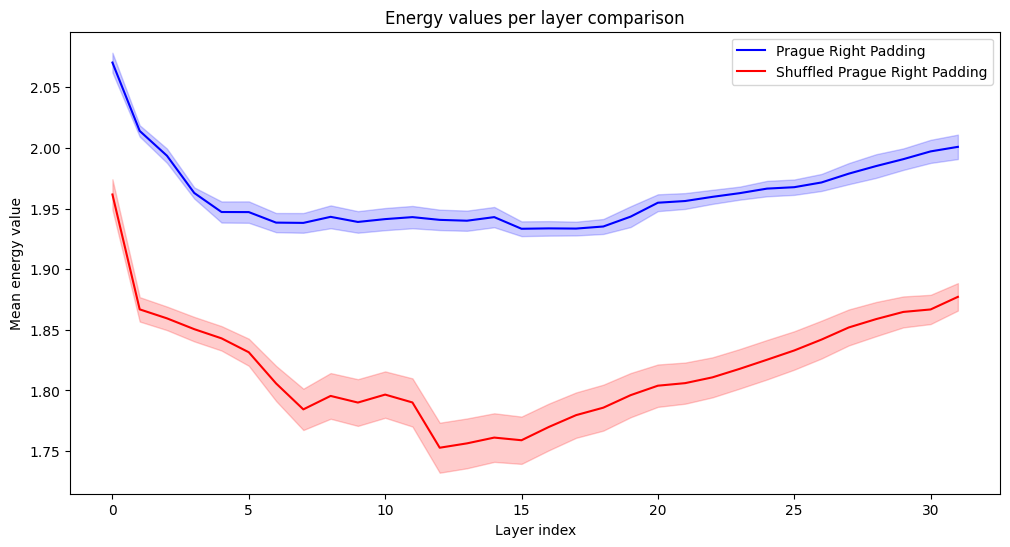

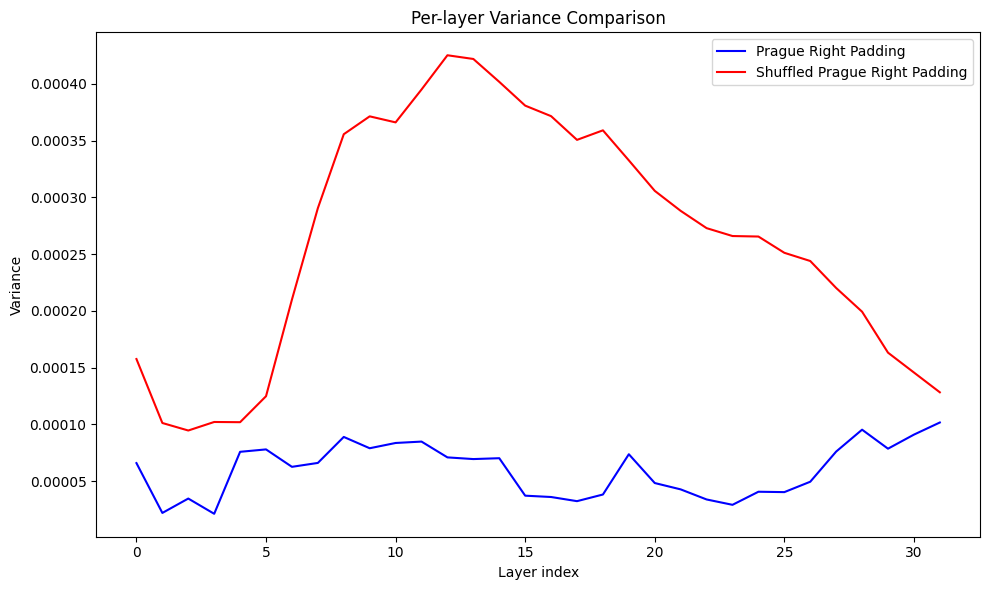

In [12]:
prague_right = [
    ("Prague Right Padding",prague_energies_right , "blue"),
    ("Shuffled Prague Right Padding", shuffled_prague_energies_right, "red"),
]
mean_and_std_by_layer_plots(prague_right)
plot_layer_variance(all_lists=prague_right)

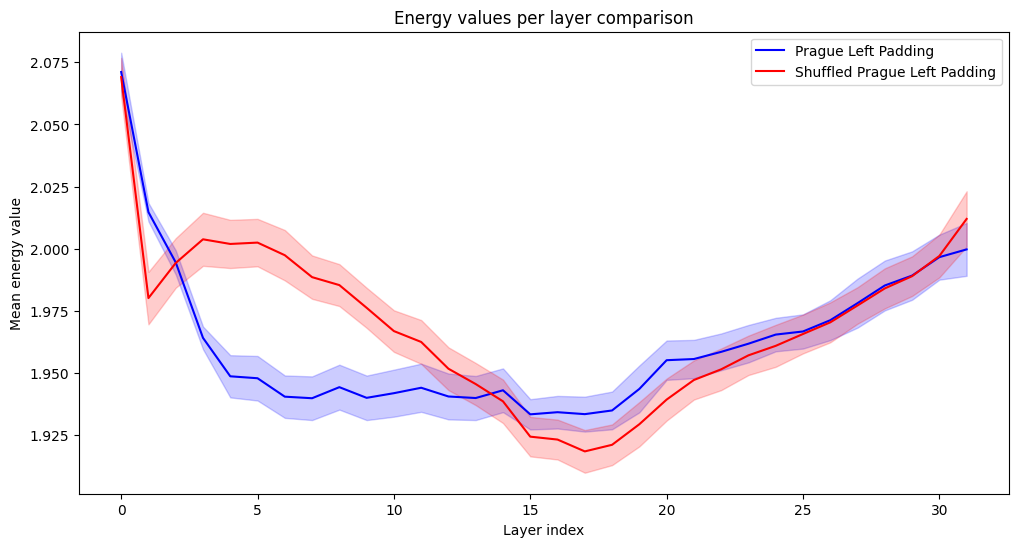

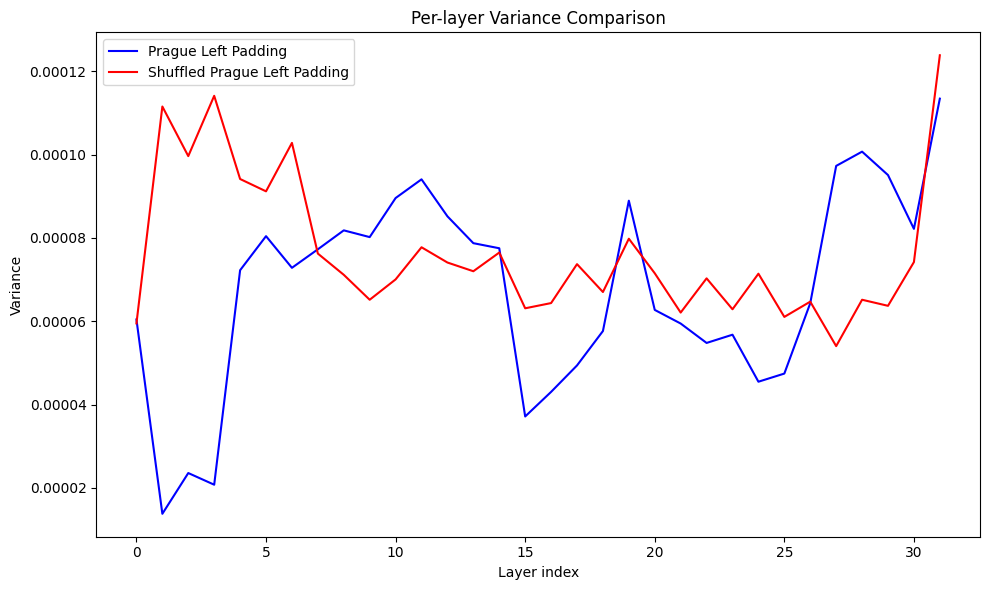

In [13]:
prague_left = [
    ("Prague Left Padding", prague_energies_left, "blue"),
    ("Shuffled Prague Left Padding", shuffled_prague_energies_left, "red"),
]
mean_and_std_by_layer_plots(prague_left)
plot_layer_variance(all_lists=prague_left)

In [14]:
prague_model_inputs, prague_ids, shuffled_prague_ids = prompt_to_shuffled(prompt_type="generation", prompt_topic="prague", tokenizer=tokenizer, terminators=terminators, device=device, rng=rng)
prague_energies_skip_tokens = inference_loop(prague_ids, prague_model_inputs, tokenizer, shuffle = False, skip_tokens = True)
shuffled_prague_energies_skip_token = inference_loop(shuffled_prague_ids, prague_model_inputs, tokenizer, shuffle = True, skip_tokens = True)

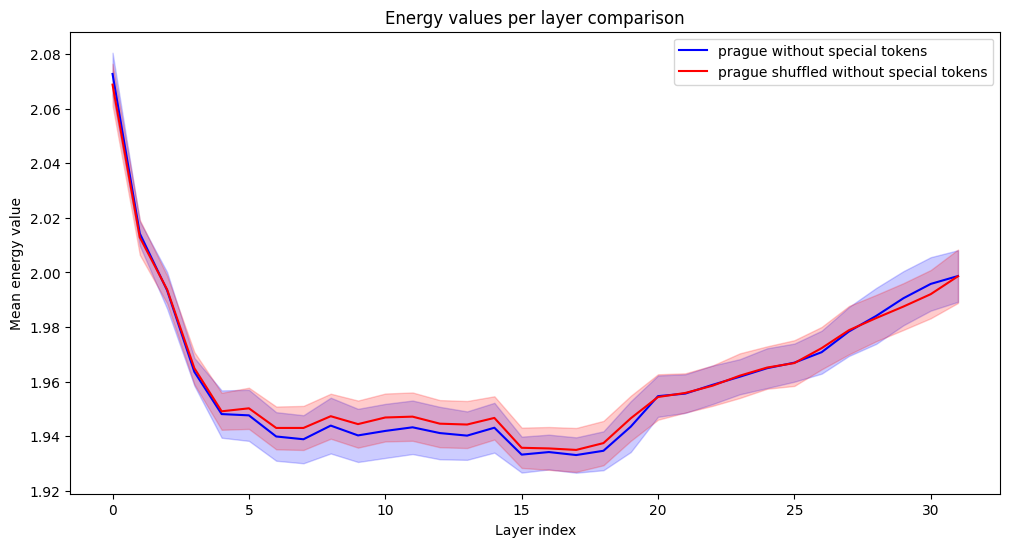

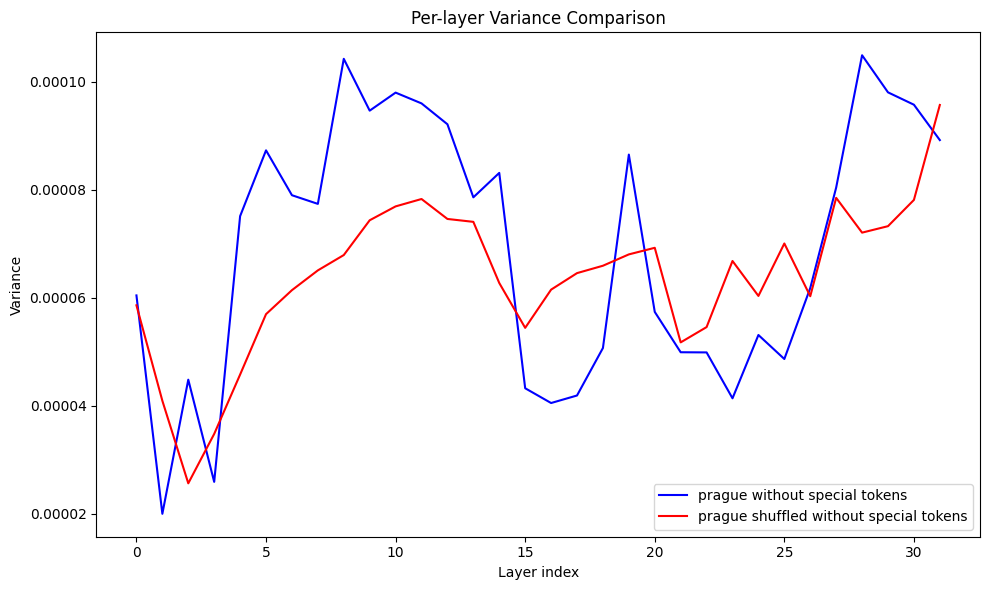

In [15]:
prague_lists_skip_tokens = [
    ("prague without special tokens", prague_energies_skip_tokens, "blue"),
    ("prague shuffled without special tokens", shuffled_prague_energies_skip_token, "red"),
]
mean_and_std_by_layer_plots(prague_lists_skip_tokens)
plot_layer_variance(all_lists=prague_lists_skip_tokens)

# Paraphrased-generated vs Shuffled 

In [13]:
def remove_clause_numbers(story: str) -> str:
    #d+ - one or more digits, \. - dot, \s* - newlines and spaces
    cleaned = re.sub(r"\d+\.\s*", "", story) 
    #remove additional spaces
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned

def tokenize_to_infer(text,tokenizer):
    tokens = tokenizer(text, padding="longest", return_tensors="pt") #transform into pt tensors
    return {key: val.to(device) for key, val in tokens.items()} #move inputs into cuda

def energy_loop_from_json(tokens, model,tokenizer,skip_tokens = False):
    gen_only = tokens["input_ids"]
    energy = []
    if skip_tokens == True:
        clean_sequences, _ = strip_special_tokens(gen_only, tokenizer)
        for seq in clean_sequences:
            if seq.numel() == 0:
                continue #handle empty generation 
            tensor = seq.unsqueeze(0)  #shape [1, seq_len]
            activations = inference_activations(model, tensor)   
            energy.append(energy_pipeline_layer(activations))

        return energy
    else:
        for i in range(gen_only.shape[0]):
            activations = inference_activations(model,gen_only[i].unsqueeze(0))
            energy.append(energy_pipeline_layer(activations))
        return energy

## First set of paraphrases

In [14]:
dir_path = "../rephrasings"

all_stories = {}
all_shuffled = {}
for i in range(1, 4):
    file = f"story{i}.json"
    shuffled_file = f"shuffled_story{i}.json"
    path = os.path.join(dir_path,file)
    shuffled_path = os.path.join(dir_path,shuffled_file)
    with open(path, "r", encoding="utf-8") as f:
        all_stories[i] = json.load(f)
    with open(shuffled_path, "r", encoding="utf-8") as f:
        all_shuffled[i] = json.load(f)

In [15]:
cleaned_stories_1 = [remove_clause_numbers(story) for story in all_stories[1]]
cleaned_stories_2 = [remove_clause_numbers(story) for story in all_stories[2]]
cleaned_stories_3 = [remove_clause_numbers(story) for story in all_stories[3]]

shuffled_1 = all_shuffled[1]
shuffled_2 = all_shuffled[2]
shuffled_3 = all_shuffled[3]

### Left Padding

In [ ]:
tokenizer.padding_side = "left"

tokens_clean1_left = tokenize_to_infer(cleaned_stories_1,tokenizer)
tokens_clean2_left = tokenize_to_infer(cleaned_stories_2,tokenizer)
tokens_clean3_left = tokenize_to_infer(cleaned_stories_3,tokenizer)

tokens_shuffled1_left = tokenize_to_infer(shuffled_1,tokenizer)
tokens_shuffled2_left = tokenize_to_infer(shuffled_2,tokenizer)
tokens_shuffled3_left = tokenize_to_infer(shuffled_3,tokenizer)

energy_clean1_left = energy_loop_from_json(tokens_clean1_left, model,tokenizer)
energy_clean2_left = energy_loop_from_json(tokens_clean2_left, model,tokenizer)
energy_clean3_left = energy_loop_from_json(tokens_clean3_left, model,tokenizer)
energy_shuffled1_left = energy_loop_from_json(tokens_shuffled1_left, model,tokenizer)
energy_shuffled2_left = energy_loop_from_json(tokens_shuffled2_left, model,tokenizer)
energy_shuffled3_left = energy_loop_from_json(tokens_shuffled3_left, model,tokenizer)

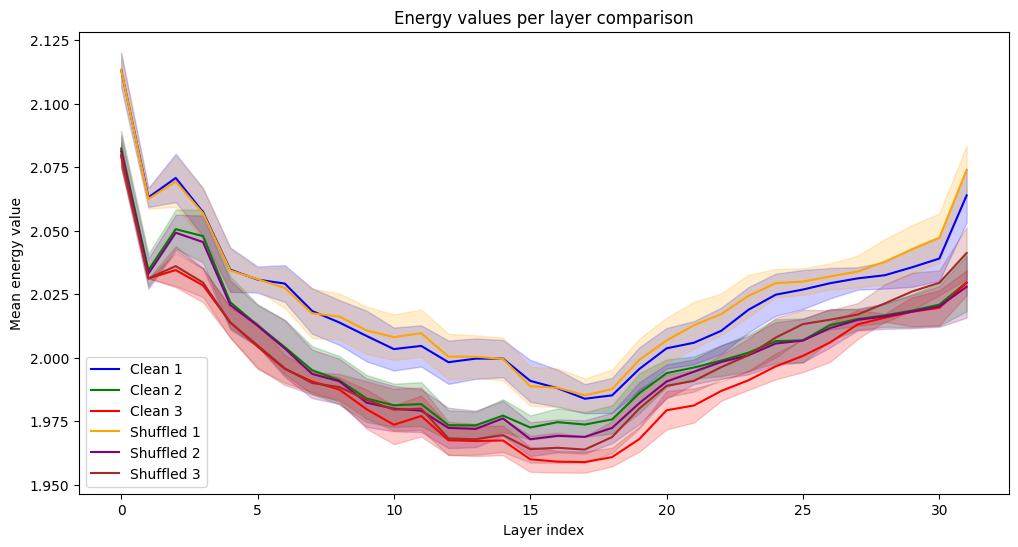

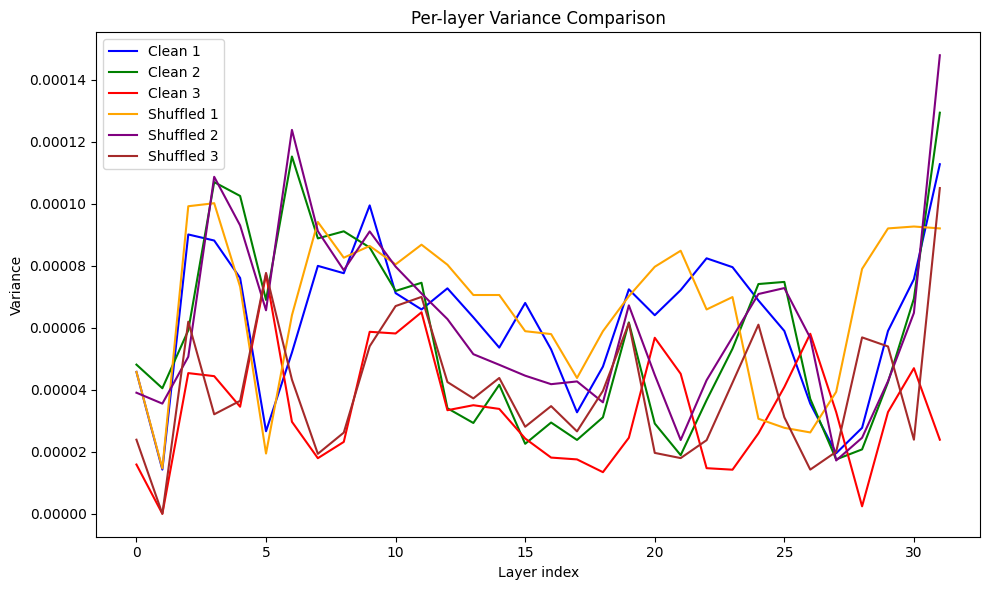

In [ ]:
first_paraphrases_left = [
    ("Clean 1 Left", energy_clean1_left, "blue"),
    ("Clean 2 Left", energy_clean2_left, "green"),
    ("Clean 3 Left", energy_clean3_left, "red"),
    ("Shuffled 1 Left", energy_shuffled1_left, "orange"),
    ("Shuffled 2 Left", energy_shuffled2_left, "purple"),
    ("Shuffled 3 Left", energy_shuffled3_left, "brown")
]

mean_and_std_by_layer_plots(first_paraphrases_left)
plot_layer_variance(first_paraphrases_left)

In [ ]:
results_1 = per_layer_ttests(energy_clean1_left, energy_shuffled1_left)

print("Significant layers (after FDR correction):", results_1["significant_layers"])
print("Corrected p-values:", results_1["pvals_corrected"])

results_2 = per_layer_ttests(energy_clean2_left, energy_shuffled2_left)

print("Significant layers (after FDR correction):", results_2["significant_layers"])
print("Corrected p-values:", results_2["pvals_corrected"])

results_3 = per_layer_ttests(energy_clean3_left, energy_shuffled3_left)

print("Significant layers (after FDR correction):", results_3["significant_layers"])
print("Corrected p-values:", results_3["pvals_corrected"])

### Right Padding

In [ ]:
tokenizer.padding_side = "right"

tokens_clean1_right = tokenize_to_infer(cleaned_stories_1,tokenizer)
tokens_clean2_right = tokenize_to_infer(cleaned_stories_2,tokenizer)
tokens_clean3_right = tokenize_to_infer(cleaned_stories_3,tokenizer)

tokens_shuffled1_right = tokenize_to_infer(shuffled_1,tokenizer)
tokens_shuffled2_right = tokenize_to_infer(shuffled_2,tokenizer)
tokens_shuffled3_right = tokenize_to_infer(shuffled_3,tokenizer)

energy_clean1_right = energy_loop_from_json(tokens_clean1_right, model,tokenizer)
energy_clean2_right = energy_loop_from_json(tokens_clean2_right, model,tokenizer)
energy_clean3_right = energy_loop_from_json(tokens_clean3_right, model,tokenizer)
energy_shuffled1_right = energy_loop_from_json(tokens_shuffled1_right, model,tokenizer)
energy_shuffled2_right = energy_loop_from_json(tokens_shuffled2_right, model,tokenizer)
energy_shuffled3_right = energy_loop_from_json(tokens_shuffled3_right, model,tokenizer)

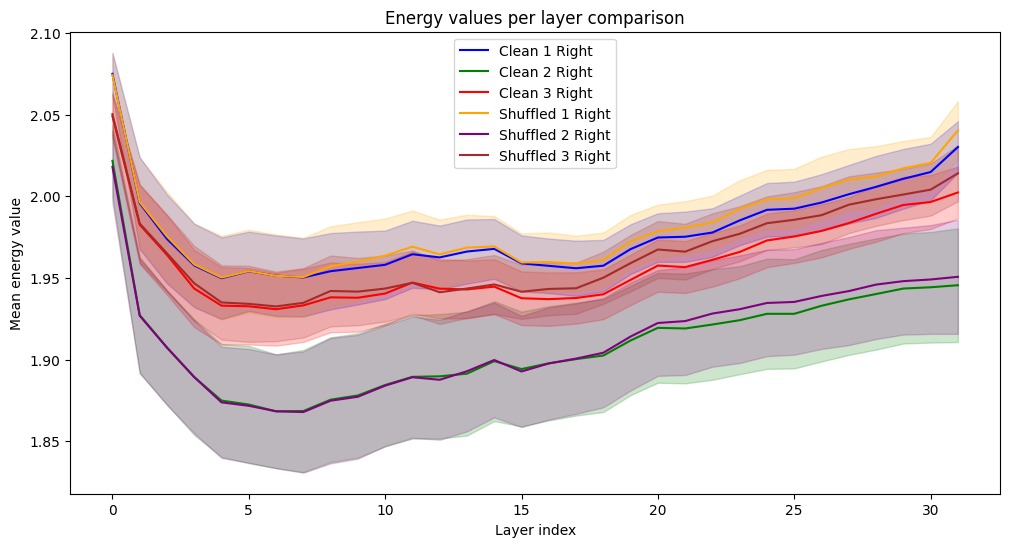

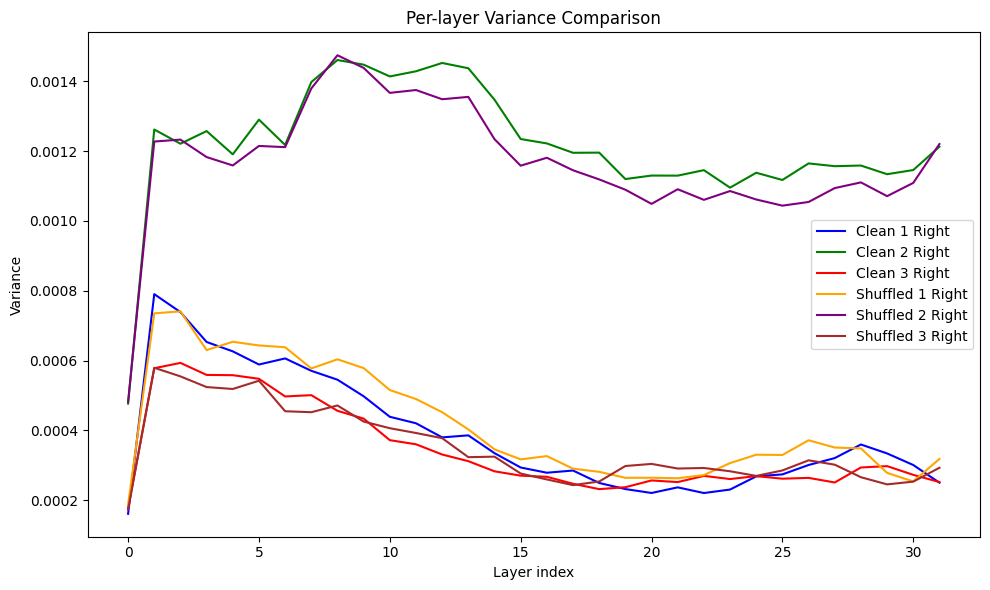

In [28]:
first_paraphrases_right = [
    ("Clean 1 Right", energy_clean1_right, "blue"),
    ("Clean 2 Right", energy_clean2_right, "green"),
    ("Clean 3 Right", energy_clean3_right, "red"),
    ("Shuffled 1 Right", energy_shuffled1_right, "orange"),
    ("Shuffled 2 Right", energy_shuffled2_right, "purple"),
    ("Shuffled 3 Right", energy_shuffled3_right, "brown")
]

mean_and_std_by_layer_plots(first_paraphrases_right)
plot_layer_variance(first_paraphrases_right)

In [30]:
results_1 = per_layer_ttests(energy_clean1_right, energy_shuffled1_right)

print("Significant layers (after FDR correction):", results_1["significant_layers"])
print("Corrected p-values:", results_1["pvals_corrected"])

results_2 = per_layer_ttests(energy_clean2_right, energy_shuffled2_right)

print("Significant layers (after FDR correction):", results_2["significant_layers"])
print("Corrected p-values:", results_2["pvals_corrected"])

results_3 = per_layer_ttests(energy_clean3_right, energy_shuffled3_right)

print("Significant layers (after FDR correction):", results_3["significant_layers"])
print("Corrected p-values:", results_3["pvals_corrected"])

Significant layers (after FDR correction): [22, 23, 24, 25, 26, 27, 29, 31]
Corrected p-values: [0.8787789641427941, 0.982451489998609, 0.8787789641427941, 0.982451489998609, 0.982451489998609, 0.982451489998609, 0.982451489998609, 0.982451489998609, 0.5971516836654152, 0.41238255068302815, 0.1762406702954473, 0.26107520868860484, 0.7542905309712622, 0.5971516836654152, 0.795740105027853, 0.982451489998609, 0.5798818804434638, 0.41238255068302815, 0.26107520868860484, 0.10012110708687354, 0.19508969252561315, 0.05125708499735351, 0.04399357163338795, 0.020687494180150413, 0.0486206143303414, 0.0486206143303414, 0.009111335614419775, 0.009111335614419775, 0.059445975465368894, 0.0486206143303414, 0.059445975465368894, 0.0011113534138473794]
Significant layers (after FDR correction): []
Corrected p-values: [0.9062793651197373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9062793651197373, 0.9062793651197373, 0.9062793651197373, 0.9

### Ignoring special tokens

In [17]:
energy_clean1_skip_tokens = energy_loop_from_json(tokens_clean1_right, model,tokenizer, skip_tokens= True)
energy_clean2_skip_tokens = energy_loop_from_json(tokens_clean2_right, model,tokenizer, skip_tokens= True)
energy_clean3_skip_tokens = energy_loop_from_json(tokens_clean3_right, model,tokenizer, skip_tokens= True)
energy_shuffled1_skip_tokens = energy_loop_from_json(tokens_shuffled1_right, model,tokenizer, skip_tokens= True)
energy_shuffled2_skip_tokens = energy_loop_from_json(tokens_shuffled2_right, model,tokenizer, skip_tokens= True)
energy_shuffled3_skip_tokens = energy_loop_from_json(tokens_shuffled3_right, model,tokenizer, skip_tokens= True)

#### First example

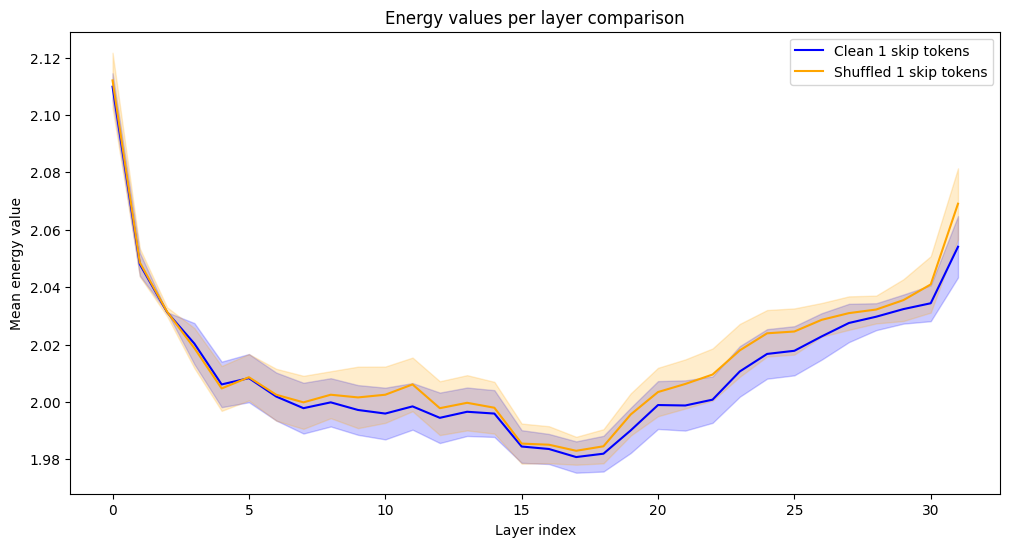

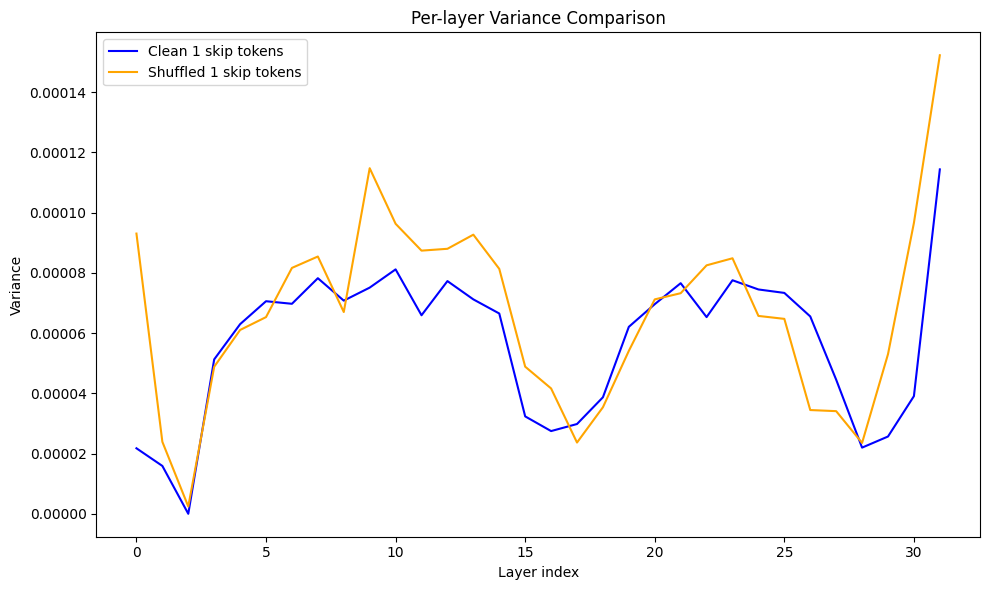

In [21]:
first_paraphrases_skip_tokens_1 = [
    ("Clean 1 skip tokens", energy_clean1_skip_tokens, "blue"),
    ("Shuffled 1 skip tokens", energy_shuffled1_skip_tokens, "orange")
]

mean_and_std_by_layer_plots(first_paraphrases_skip_tokens_1)
plot_layer_variance(first_paraphrases_skip_tokens_1)

#### Second example

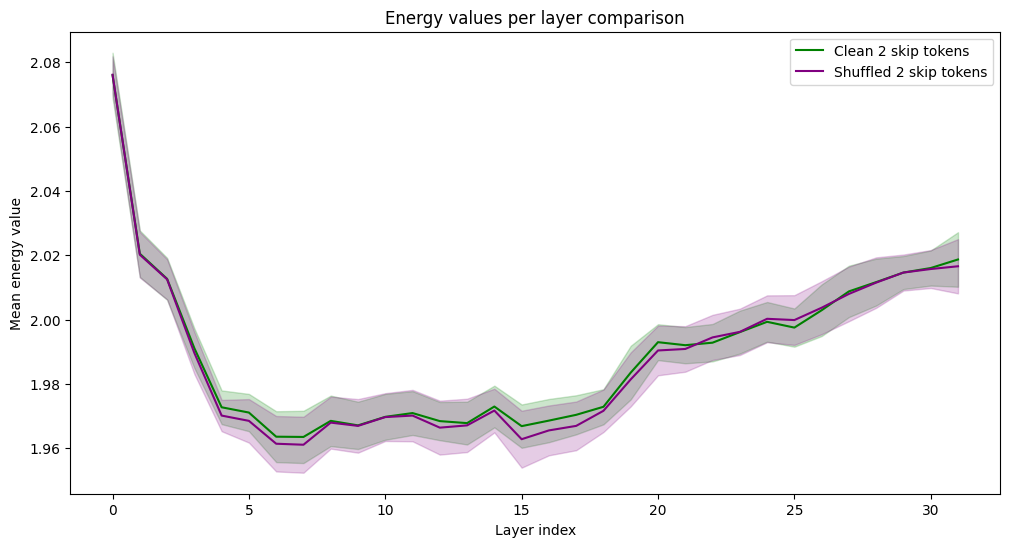

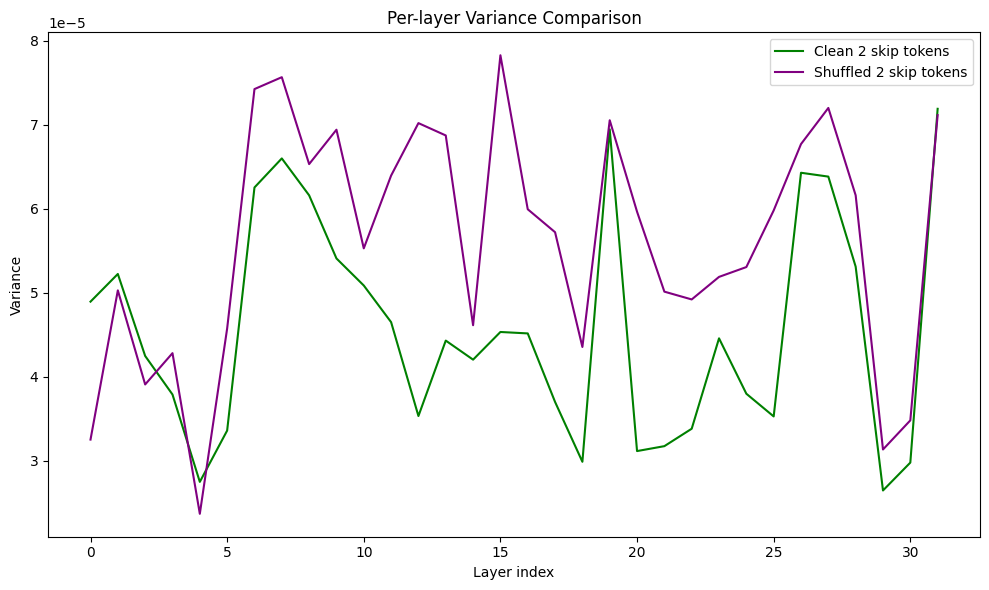

In [22]:
first_paraphrases_skip_tokens_2 = [
    ("Clean 2 skip tokens", energy_clean2_skip_tokens, "green"),
    ("Shuffled 2 skip tokens", energy_shuffled2_skip_tokens, "purple")
]

mean_and_std_by_layer_plots(first_paraphrases_skip_tokens_2)
plot_layer_variance(first_paraphrases_skip_tokens_2)

#### Third example

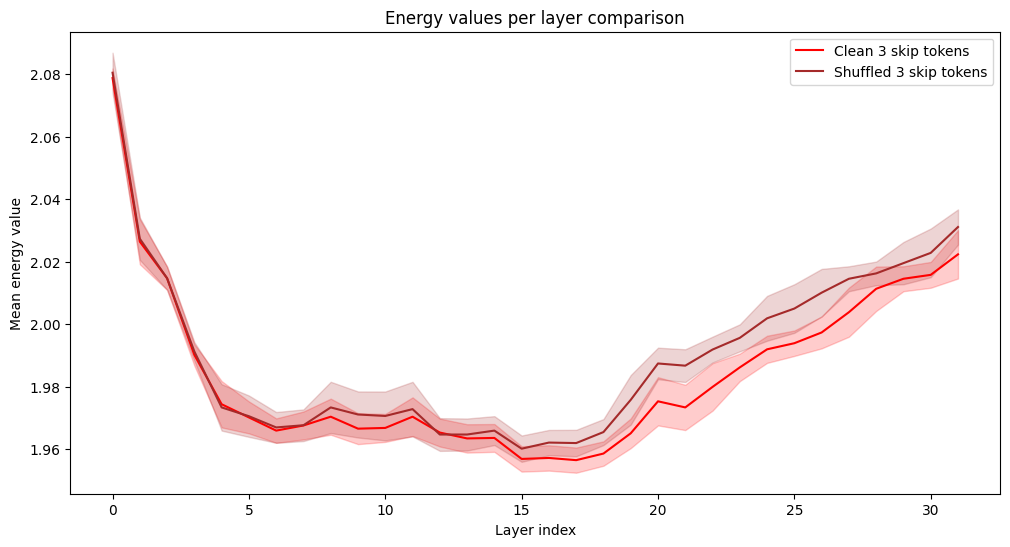

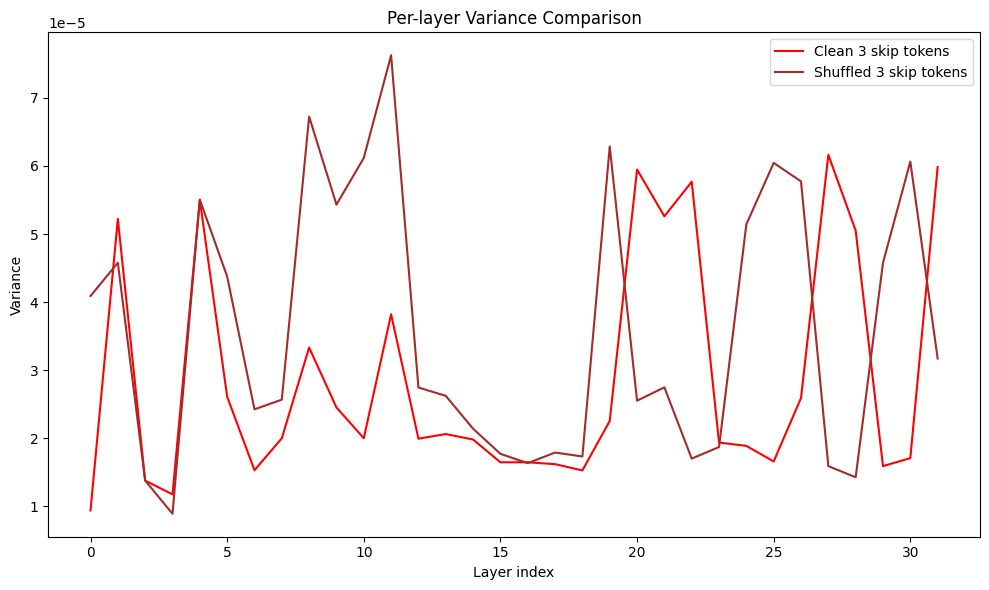

In [23]:
first_paraphrases_skip_tokens_3 = [
    ("Clean 3 skip tokens", energy_clean3_skip_tokens, "red"),
    ("Shuffled 3 skip tokens", energy_shuffled3_skip_tokens, "brown")
]

mean_and_std_by_layer_plots(first_paraphrases_skip_tokens_3)
plot_layer_variance(first_paraphrases_skip_tokens_3)

#### Everything

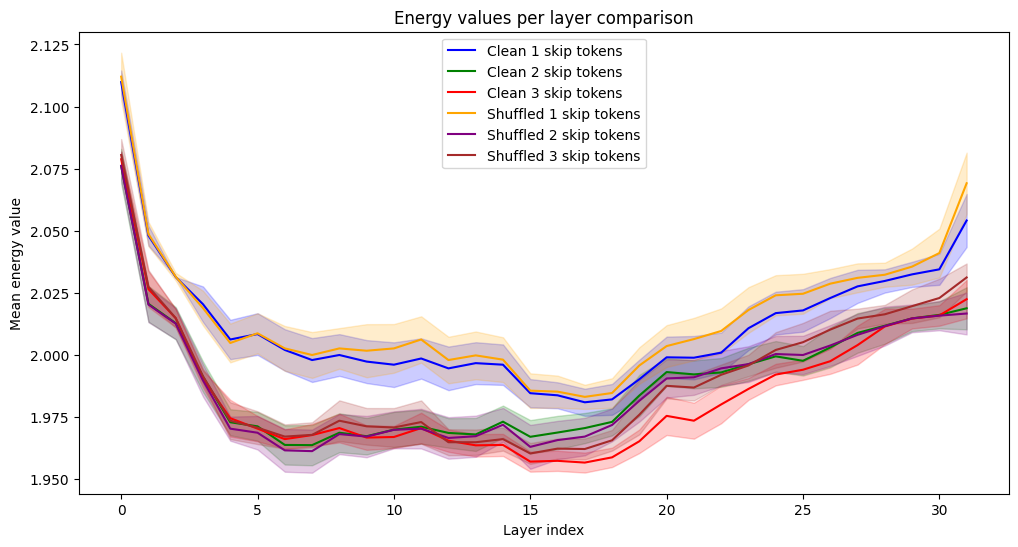

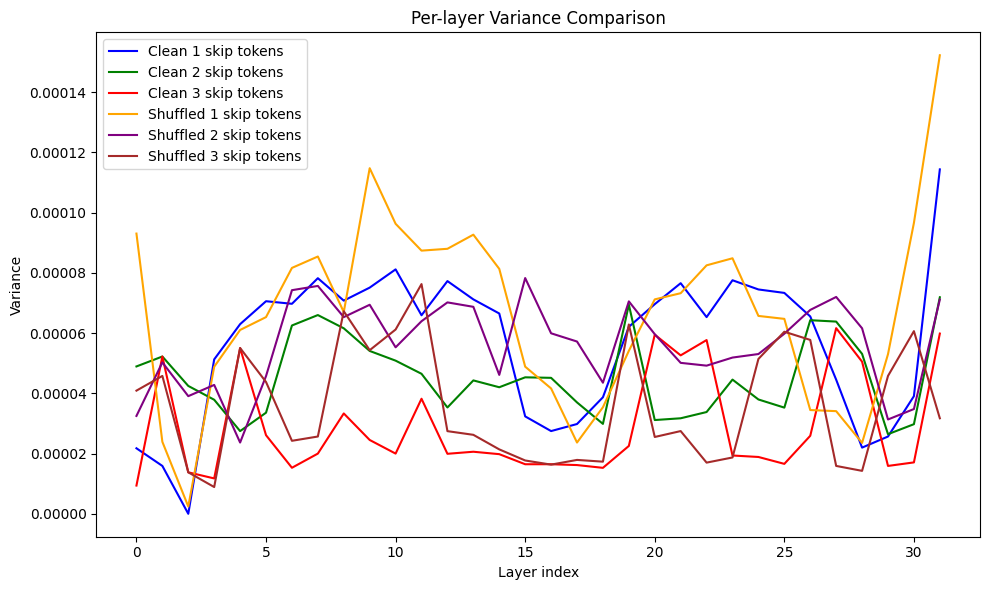

In [18]:
first_paraphrases_skip_tokens = [
    ("Clean 1 skip tokens", energy_clean1_skip_tokens, "blue"),
    ("Clean 2 skip tokens", energy_clean2_skip_tokens, "green"),
    ("Clean 3 skip tokens", energy_clean3_skip_tokens, "red"),
    ("Shuffled 1 skip tokens", energy_shuffled1_skip_tokens, "orange"),
    ("Shuffled 2 skip tokens", energy_shuffled2_skip_tokens, "purple"),
    ("Shuffled 3 skip tokens", energy_shuffled3_skip_tokens, "brown")
]

mean_and_std_by_layer_plots(first_paraphrases_skip_tokens)
plot_layer_variance(first_paraphrases_skip_tokens)

In [19]:
results_1 = per_layer_ttests(energy_clean1_skip_tokens, energy_shuffled1_skip_tokens)

print("Significant layers (after FDR correction):", results_1["significant_layers"])
print("Corrected p-values:", results_1["pvals_corrected"])

results_2 = per_layer_ttests(energy_clean2_skip_tokens, energy_shuffled2_skip_tokens)

print("Significant layers (after FDR correction):", results_2["significant_layers"])
print("Corrected p-values:", results_2["pvals_corrected"])

results_3 = per_layer_ttests(energy_clean3_skip_tokens, energy_shuffled3_skip_tokens)

print("Significant layers (after FDR correction):", results_3["significant_layers"])
print("Corrected p-values:", results_3["pvals_corrected"])

Significant layers (after FDR correction): [8, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Corrected p-values: [0.06409432325284004, 0.34727425803839346, 0.34727425803839346, 0.14988467902271016, 0.24939268955243604, 0.7899093074697063, 0.6335276223588759, 0.1481464193173737, 0.038758008803365135, 0.0036799156923187893, 5.764826571340816e-06, 4.453455459525023e-08, 0.0168789182265653, 0.025676567764459778, 0.1307233492828361, 0.3011268056661775, 0.10737797423827657, 0.005833395963614559, 0.005833395963614559, 2.3129071745885963e-06, 0.0004745444904717295, 4.453455459525023e-08, 2.540082946634895e-10, 1.6868869472644265e-07, 4.827396309856425e-08, 1.8209887158760748e-07, 1.6868869472644265e-07, 0.00041504210411661807, 0.0006688227895862702, 0.0012313898699447415, 2.9639533552837126e-07, 2.6912391955225885e-15]
Significant layers (after FDR correction): [4, 5, 15, 16, 17, 20]
Corrected p-values: [0.9701864042496415, 0.9701864042496415, 0.970186404249641

/home/jdias/miniconda3/envs/vf/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


## Second set of paraphrases